In [1]:
import sounddevice as sd
import wave
import speech_recognition as sr
import keyboard 
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline
import librosa.display
from IPython.display import Audio
import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import splitfolders
import skimage.io

2024-05-17 23:56:36.343060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/var/folders/61/j5hgpw591h5654xxhycthpfm0000gn/T/ipykernel_63967/1186123310.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, max_points=11025, x_axis='s')


The sampled audio is returned as a numpy array (TS) and has  (76023,)  number of samples
The 10 randomly picked consequitive samples of the audio are:  [0.00010739 0.0001608  0.00014981 0.00028183 0.00045872 0.00065484
 0.00076886 0.00103632 0.00125435 0.00135435]


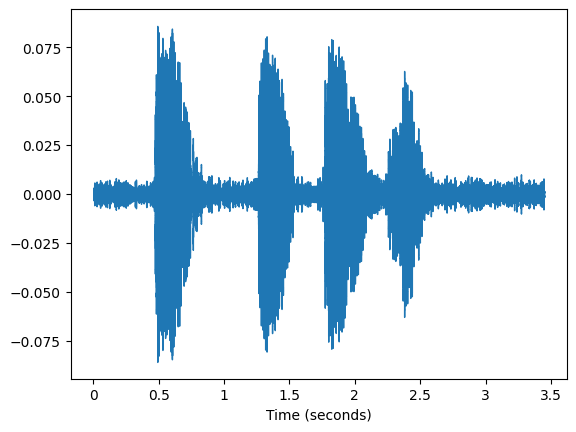

In [2]:
y, sr = librosa.load('/Users/paulchang/Desktop/audio_ml/hello_how_are_u.wav', sr=23000)
librosa.display.waveshow(y, max_points=11025, x_axis='s')
print("The sampled audio is returned as a numpy array (TS) and has ", y.shape, " number of samples")
print("The 10 randomly picked consequitive samples of the audio are: " , y[3000:3010])

Sampling rate tells us how many samples the audio will be broken down into per second. We can extract features from the time domain signal, or convert it into the frequency domain signal.

In [3]:
# Hear the audio
Audio('/Users/paulchang/Desktop/audio_ml/hello_how_are_u.wav')

The Spectrum is the set of frequencies that make up a specific signal. The lowest frequency in a signal called the fundamental frequency. Frequencies that are whole number multiples of the fundamental frequency are known as harmonics. The spectrum of a signal (especially of a non-periodic) changes with time. Therefore, the common approach is to find the spectrum for small fixed section of a signal at a time. This is repeated until we have traversed all of sampled signal. The spectrum for all of the individual sections of a signal are stacked together and that gives us the spectrogram. 

Another key thing is that spectrum is found by taking the Fourier Transform of the signal in a time domain. The approach that is normally taken in to divide the sampled signal into equal parts and take the Fourier Transform of each part individually. This is also called STFT because we are taking Fourier Transform for a small segment of a signal (short term). Therefore, when we want to take the STFT of a signal, we need to specify how many samples we should consider at a time.

Spectrogram is represented as a matrix.

In [4]:
# Size of the Fast Fourier Transform (FFT), which will also be used as the window length
n_fft=2048

# Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
hop_length=512

# Specify the window type for FFT/STFT
window_type = 'hann'

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type)) ** 2

print("The shape of spectrogram_librosa is: ", spectrogram_librosa.shape)
print("The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])")
print("The frame size that we have specficied is the number of samples to consider for the STFT. In our case, it is equal to the n_fft",n_fft, " samples")
print("The number of frames depends on the total lenght of the sampled signal, the number of samples in each frame and the hop lenghth.")

The shape of spectrogram_librosa is:  (1025, 149)
The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])
The frame size that we have specficied is the number of samples to consider for the STFT. In our case, it is equal to the n_fft 2048  samples
The number of frames depends on the total lenght of the sampled signal, the number of samples in each frame and the hop lenghth.


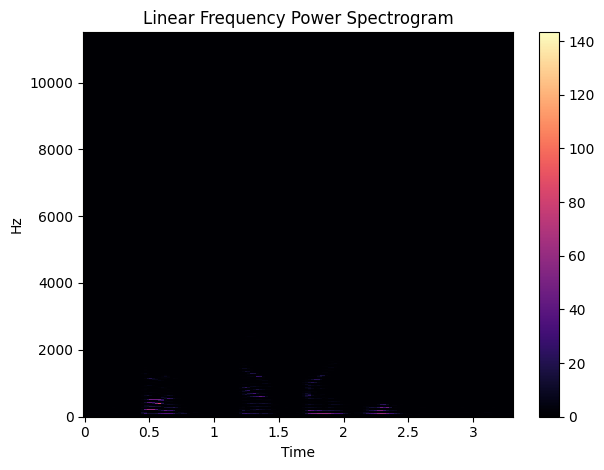

In [5]:
librosa.display.specshow(spectrogram_librosa, sr=sr, x_axis='time', y_axis='linear', hop_length=hop_length)
plt.title('Linear Frequency Power Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

The change of scale is done so that we can actually get a spectrogram from which we can visually infer some meaningful information. The spectrogram above is hard to read as our hearing range is limited to a small set of frequencies and amplitudes.

Humans perceive amplitude of a sound as its loudness. We hear loudness logarithmically rather than linearly. This is accounted for with a Decibel scale. 0 dB is silence. 10 dB is 10 times louder than 0 dB. 20 dB is 100 times louder, 30 dB is 1000 times louder, and so on...

meaning we can easily tell the differences between lower frequencies (such as between 100 Hz and 200 Hz) but we can hardly tell the differences between higher frequencies (such as 10000 Hz and 100100 Hz). In both cases, the difference in frequency is 100 Hz but to a human ear, 200 Hz appears farther apart than 100 Hz. However, looking at it differently, in the 100 Hz - 200 Hz pair, the second frequency is double the first frequency, whereas in the 10000 Hz - 100100 Hz pair, the second frequency is only 1% more than the first one. Therefore, we can say that we hear them on a logarithmic scale rather than a linear scale. This gave rise to a Mel scale.

It is important for us to use a logarithmic scale via the Mel Scale (for frequency) and the Decibel scale (for amplitude) when dealing with Frequencies and Amplitudes for an audio input.

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant.

In ML applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters (called Mel filter bank) that compute the energy of the spectrum in each band.

The shape of the Mel spectrogram is [number of mel bands x (frame_size / 2)] + 1, where frame_size is the number of FFR components (n_fft)

The shape of mel spectrogram is:  (64, 149)


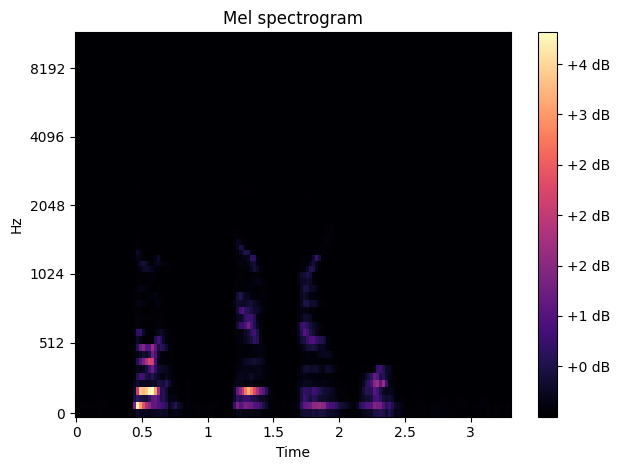

In [6]:
mel_bins = 64
fmin = 0
fmax = sr // 2
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, fmin=fmin, fmax=fmax)
print("The shape of mel spectrogram is: ", mel_spectrogram.shape)

librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

The shape of Log Mel spectrogram is  (64, 149)


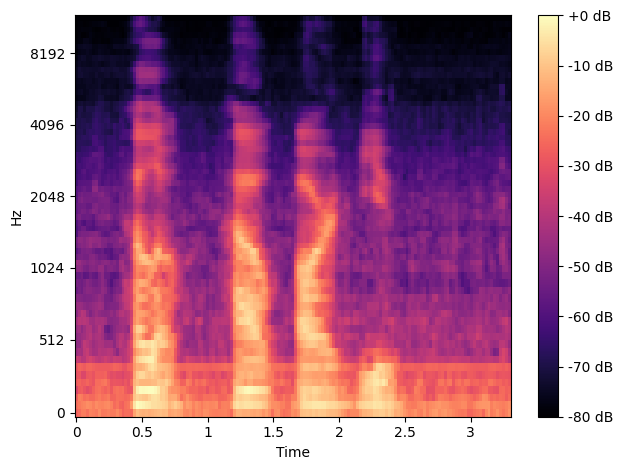

In [7]:
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is ", mel_spectrogram_db.shape)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [8]:
# Parameters for windowing
window_size = int(0.025 * sr)  # 25 ms
stride = int(0.010 * sr)       # 10 ms

# Calculate the number of segments
num_segments = (len(y) - window_size) // stride + 1

# Initialize an array to hold the segments
segments = np.empty((num_segments, window_size))

# Extract the segments
for i in range(num_segments):
    start = i * stride
    end = start + window_size
    segments[i] = y[start:end]

# Energy thresholding to detect speech
energy = np.sum(segments**2, axis=1)  # Compute energy of each segment
energy_threshold = np.max(energy) * 0.1  # Set a threshold for speech detection (10% of max energy)

# Detect phoneme segments
phoneme_indices = np.where(energy > energy_threshold)[0]

# Combine consecutive indices into intervals
intervals = []
start_idx = phoneme_indices[0]
for i in range(1, len(phoneme_indices)):
    if phoneme_indices[i] != phoneme_indices[i - 1] + 1:
        intervals.append((start_idx, phoneme_indices[i - 1]))
        start_idx = phoneme_indices[i]
intervals.append((start_idx, phoneme_indices[-1]))

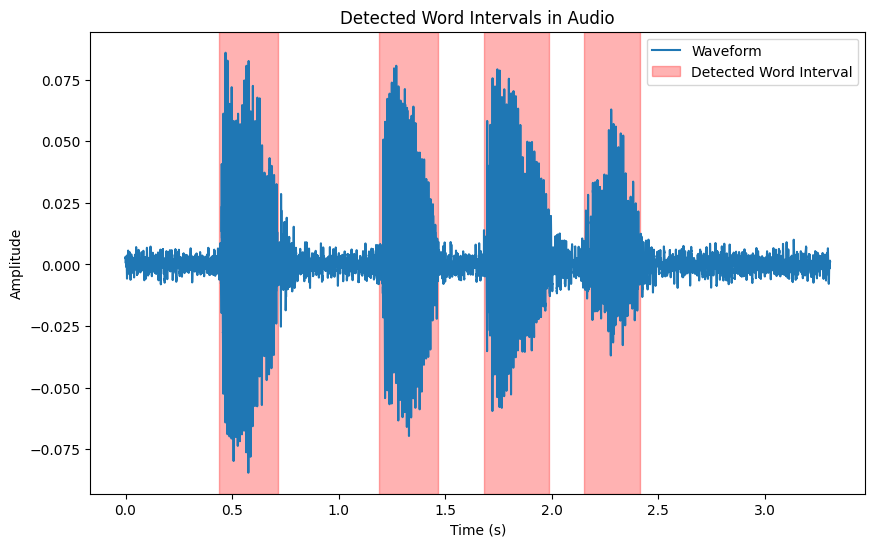

Detected word intervals: [(44, 69), (119, 144), (168, 196), (215, 239)]


In [9]:
# Visualize detected phoneme intervals with time on x-axis
t = np.linspace(0, len(y) / sr, len(y))
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Waveform')
for start, end in intervals:
    plt.axvspan(start * stride / sr, (end * stride + window_size) / sr, color='r', alpha=0.3, label='Detected Word Interval' if start == intervals[0][0] else "")
plt.title('Detected Word Intervals in Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print detected phoneme intervals
print("Detected word intervals:", intervals)

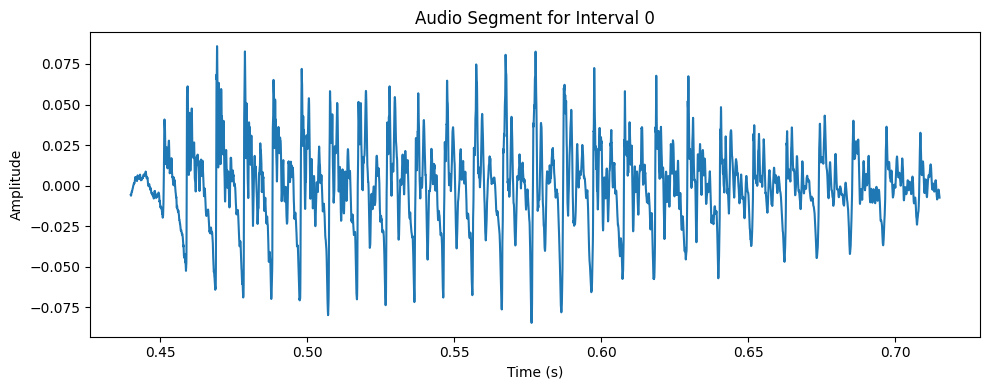

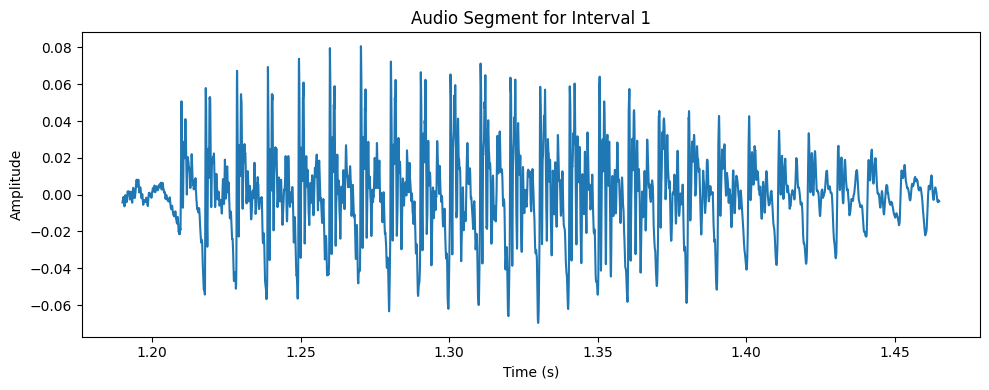

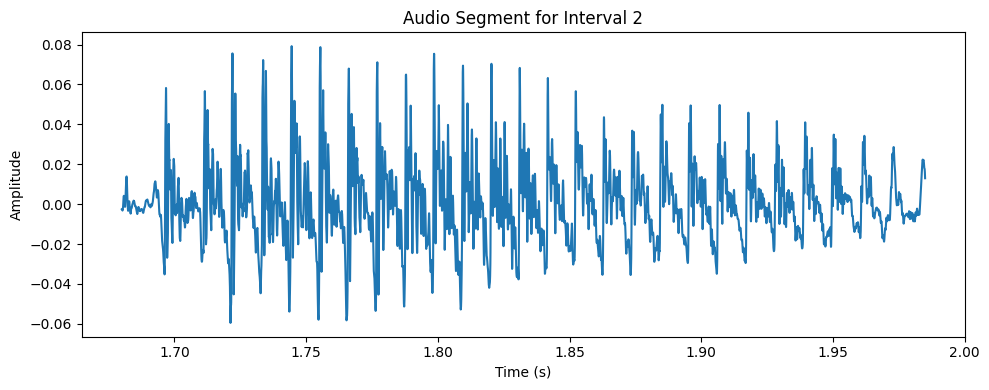

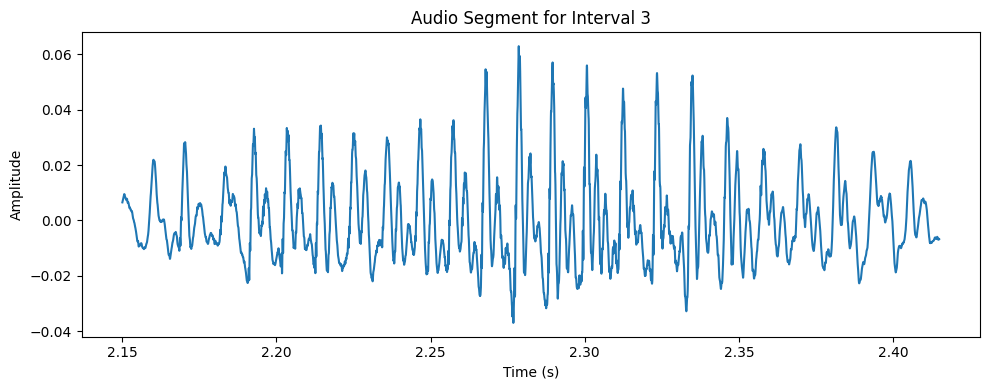

In [10]:
# Function to extract and plot audio segments with correct time intervals
def extract_and_plot_segment(y, sr, start, end, interval_idx):
    # Extract segment
    segment = y[start:end]

    # Create time axis for the segment
    t = np.linspace(start / sr, end / sr, len(segment))
    
    # Visualize the segment
    plt.figure(figsize=(10, 4))
    plt.plot(t, segment)
    plt.title(f'Audio Segment for Interval {interval_idx}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Extract and plot audio segments for each detected interval
for idx, (start, end) in enumerate(intervals):
    #update count for each word 
    extract_and_plot_segment(y, sr, start * stride, end * stride + window_size, idx)

In [11]:
import nltk
from nltk.corpus import cmudict
import re

nltk.download('cmudict')

def get_phonemes(word):
    pron_dict = cmudict.dict()
    
    word = word.lower()
  
    phonemes = pron_dict.get(word)
    
    # Remove numeric values from the phonemes
    if phonemes:
        phonemes = [[re.sub(r'\d', '', phoneme) for phoneme in variant] for variant in phonemes]
        return phonemes[0]  # return the first pronunciation variant
    else:
        return f"No phoneme representation found for '{word}'."

sentence = "Hello how are you."
print("Sentence:", sentence)
words = sentence.split()

# Remove non-alphabetic characters using regex
word_regex = re.compile(r'[^a-zA-Z]')
words = [word_regex.sub('', word) for word in words]

print("Words:", words)
sentence_phonemes = [get_phonemes(word) for word in words]
print("Phonemes:", sentence_phonemes)

[nltk_data] Error loading cmudict: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


Sentence: Hello how are you.
Words: ['Hello', 'how', 'are', 'you']
Phonemes: [['HH', 'AH', 'L', 'OW'], ['HH', 'AW'], ['AA', 'R'], ['Y', 'UW']]


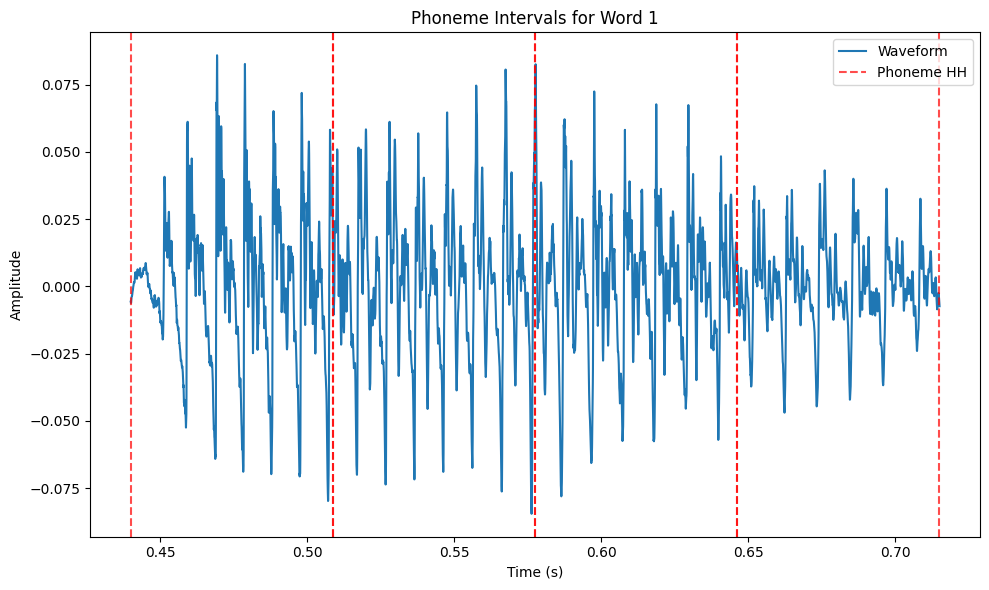

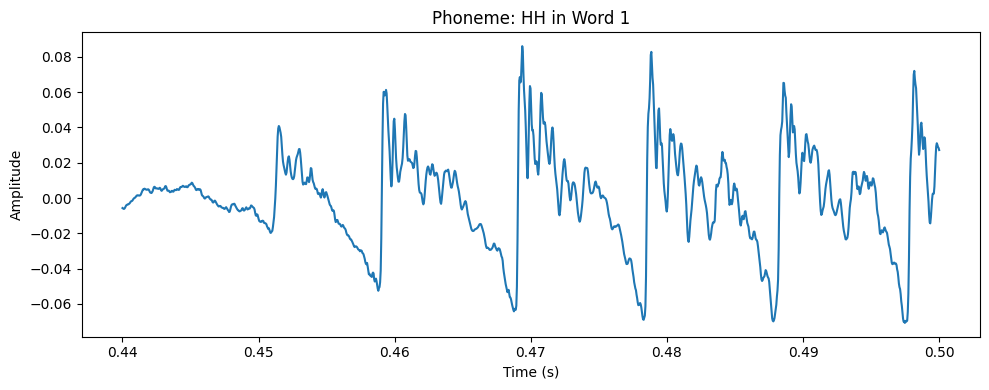

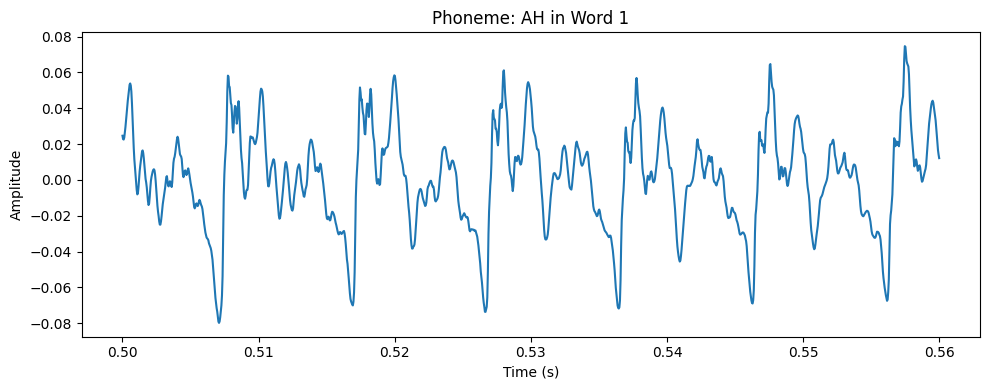

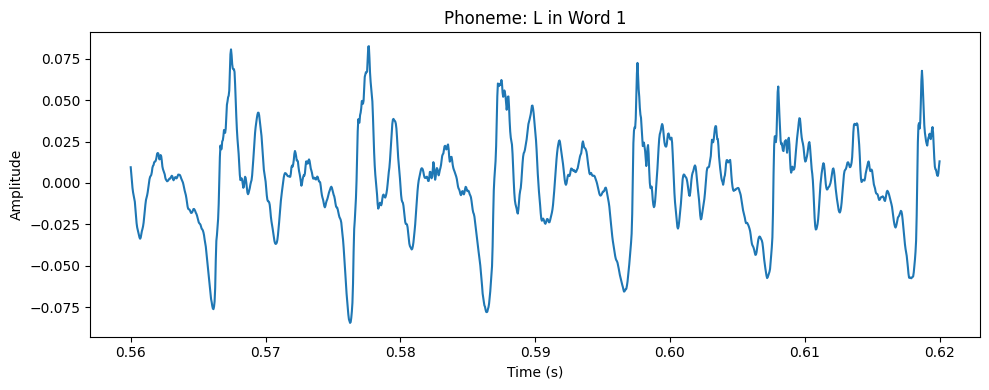

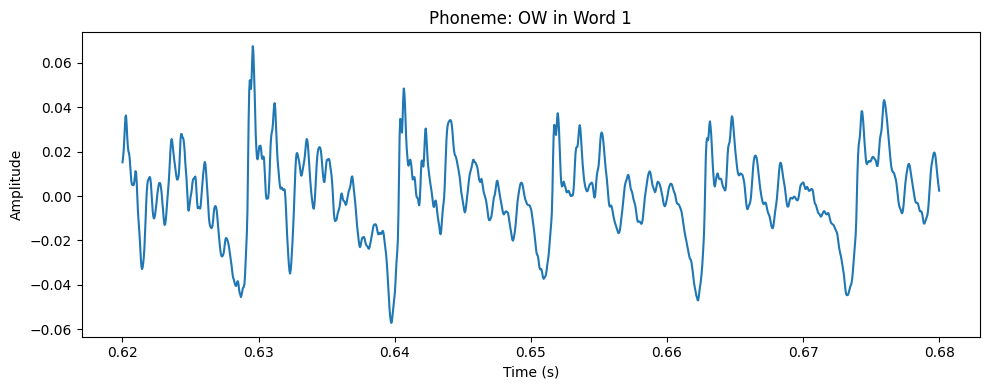

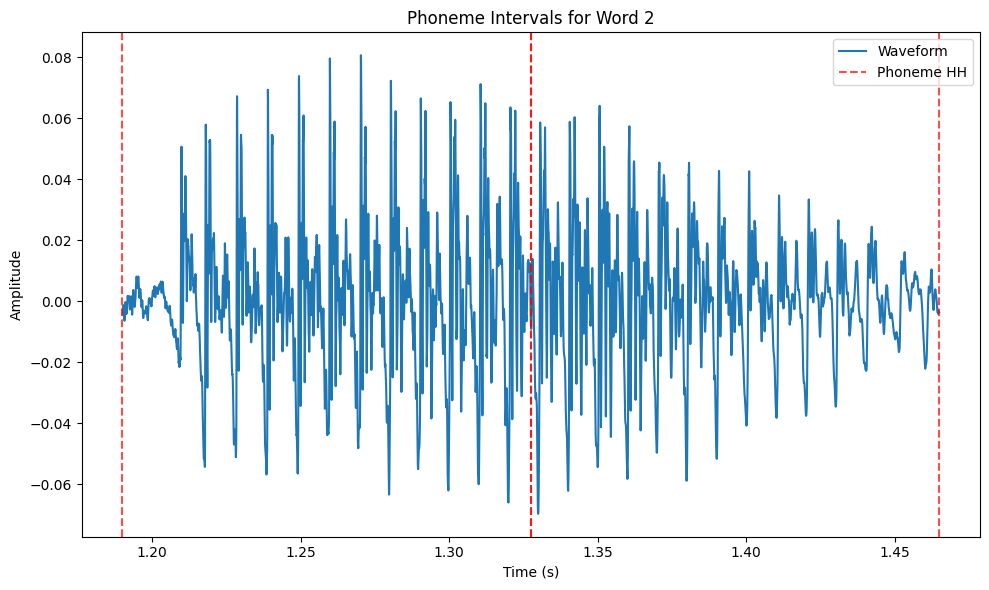

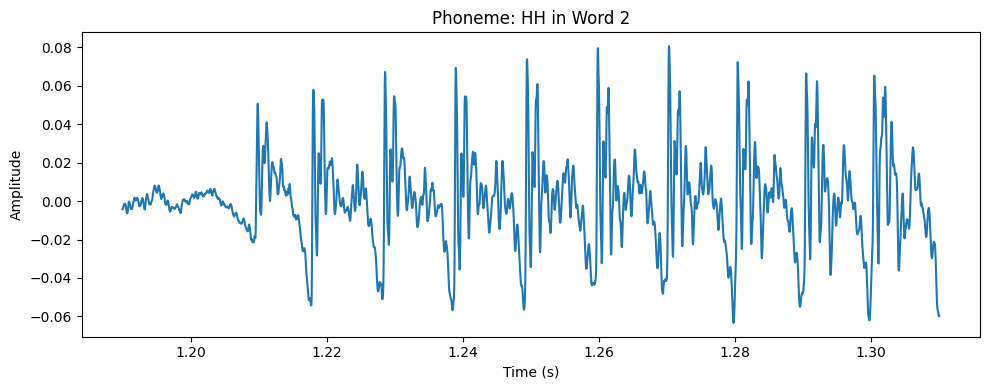

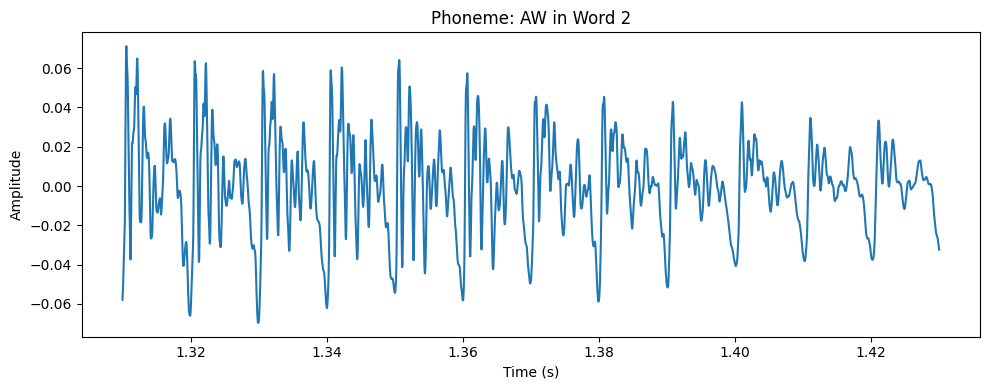

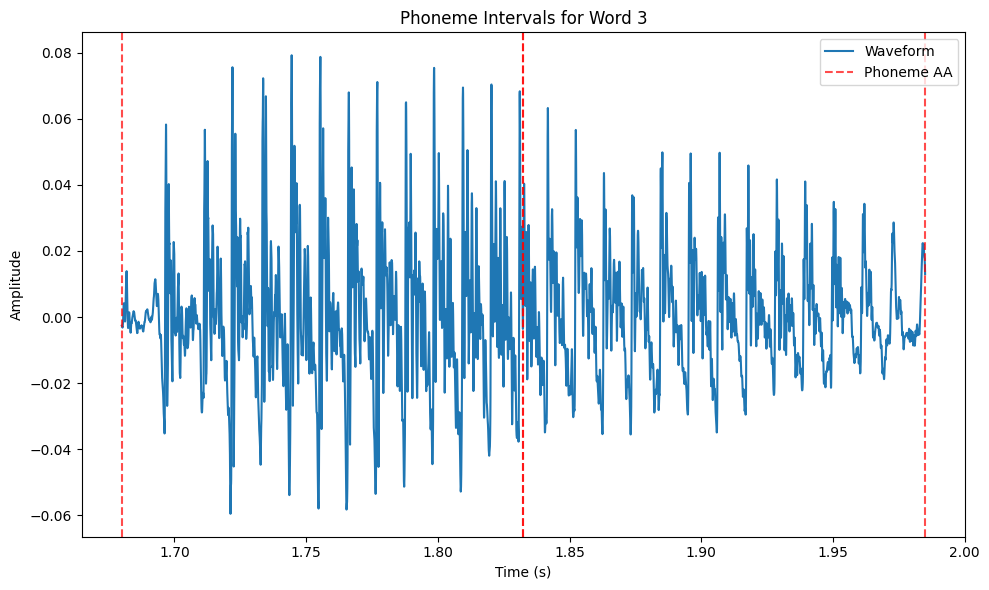

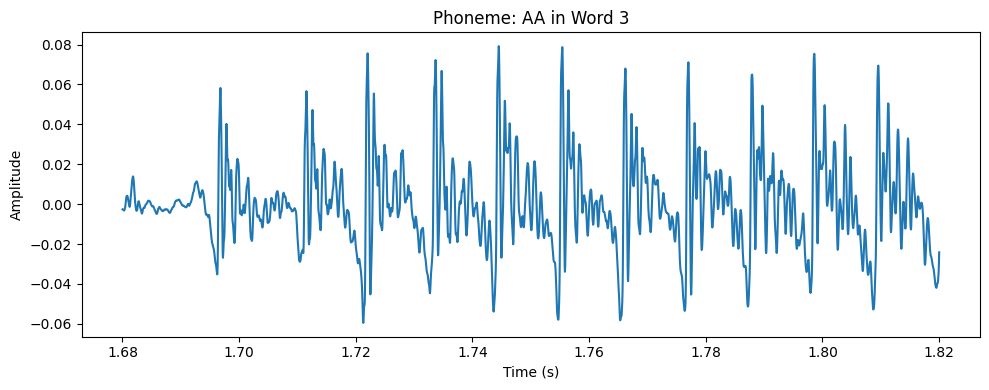

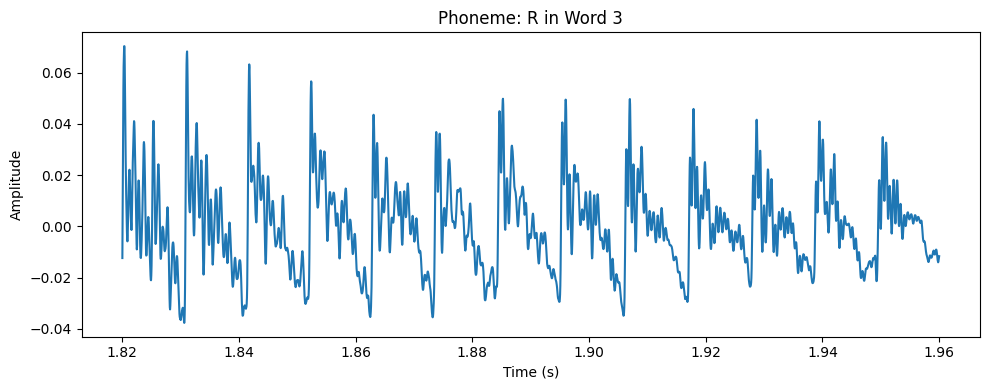

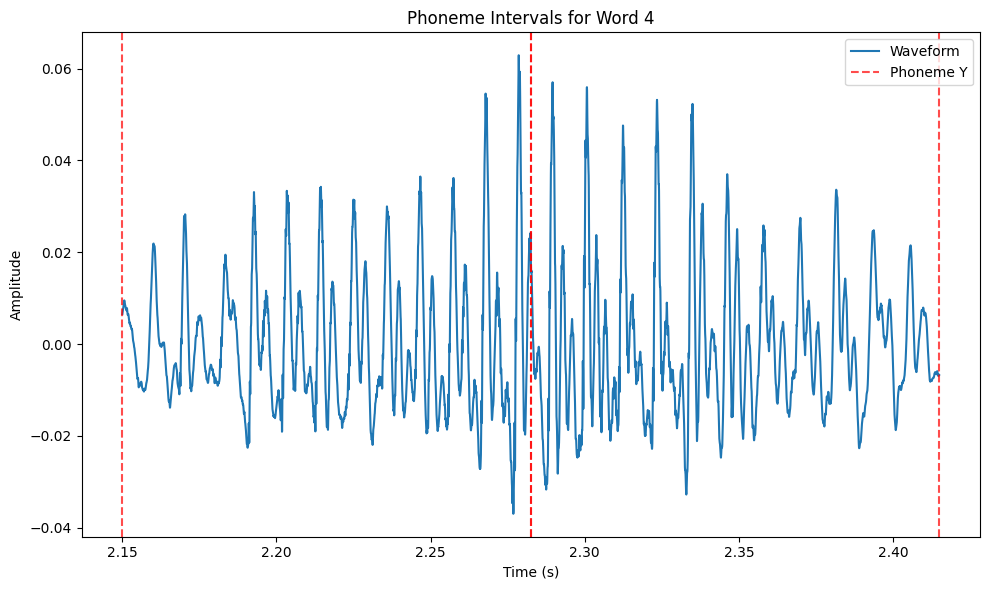

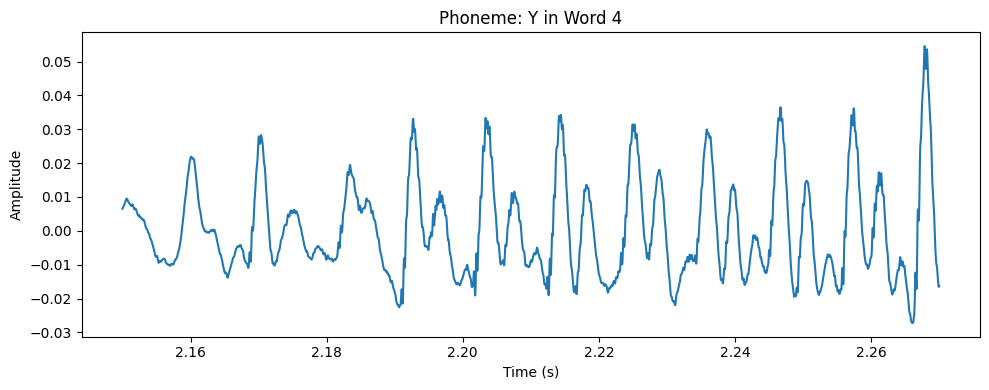

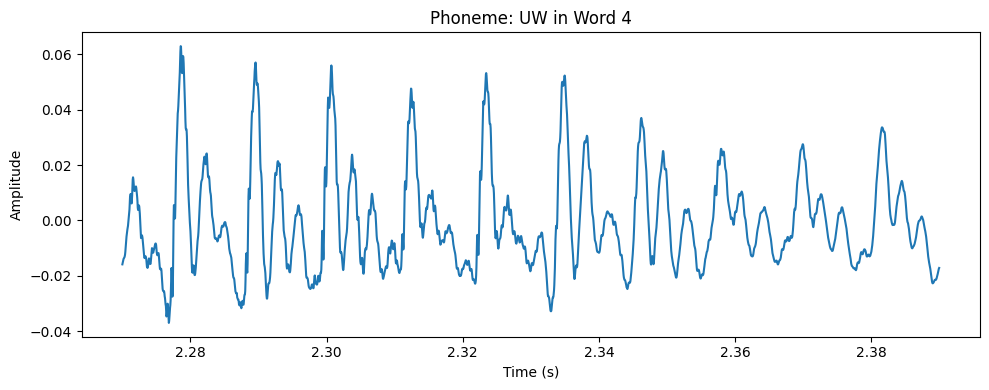

In [12]:
# Function to plot phoneme intervals
def plot_phoneme_intervals(y, sr, intervals, phonemes, word_idx):
    word_start, word_end = intervals[word_idx]
    t = np.linspace(word_start * stride / sr, (word_end * stride + window_size) / sr, len(y[word_start * stride: word_end * stride + window_size]))
    plt.figure(figsize=(10, 6))
    plt.plot(t, y[word_start * stride: word_end * stride + window_size], label='Waveform')
    
    phoneme_length = len(y[word_start * stride: word_end * stride + window_size]) // len(phonemes)
    for i, phoneme in enumerate(phonemes):
        start_phoneme = word_start * stride + i * phoneme_length
        end_phoneme = start_phoneme + phoneme_length
        plt.axvline(x=start_phoneme / sr, color='r', linestyle='--', alpha=0.7, label=f'Phoneme {phoneme}' if i == 0 else "")
        plt.axvline(x=end_phoneme / sr, color='r', linestyle='--', alpha=0.7)

    plt.title(f'Phoneme Intervals for Word {word_idx + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot individual phoneme segments
def plot_individual_phonemes(y, sr, intervals, phonemes, word_idx):
    word_start, word_end = intervals[word_idx]
    phoneme_length = (word_end - word_start) // len(phonemes)
    
    for i, phoneme in enumerate(phonemes):
        start_phoneme = word_start * stride + i * phoneme_length * stride
        end_phoneme = start_phoneme + phoneme_length * stride
        t = np.linspace(start_phoneme / sr, end_phoneme / sr, len(y[start_phoneme: end_phoneme]))
        plt.figure(figsize=(10, 4))
        plt.plot(t, y[start_phoneme: end_phoneme])
        plt.title(f'Phoneme: {phoneme} in Word {word_idx + 1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

# Plotting
for word_idx, phonemes in enumerate(sentence_phonemes):
    plot_phoneme_intervals(y, sr, intervals, phonemes, word_idx)
    plot_individual_phonemes(y, sr, intervals, phonemes, word_idx)

In [13]:
# Function to compute MFCCs for each phoneme segment
def compute_mfcc(y, sr, start, end, n_mfcc=13):
    segment = y[start:end]
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Function to extract phoneme MFCCs
def extract_phoneme_mfccs(y, sr, intervals, phonemes, word_idx, n_mfcc=13):
    word_start, word_end = intervals[word_idx]
    phoneme_length = (word_end - word_start) // len(phonemes)
    
    phoneme_mfccs = []
    
    for i, phoneme in enumerate(phonemes):
        start_phoneme = word_start * stride + i * phoneme_length * stride
        end_phoneme = start_phoneme + phoneme_length * stride
        mfccs = compute_mfcc(y, sr, start_phoneme, end_phoneme, n_mfcc)
        phoneme_mfccs.append((phoneme, mfccs))
    
    return phoneme_mfccs


# List to store all phoneme MFCCs
all_phoneme_mfccs = []

# Extract and save MFCCs for each phoneme in each word
for word_idx, phonemes in enumerate(sentence_phonemes):
    phoneme_mfccs = extract_phoneme_mfccs(y, sr, intervals, phonemes, word_idx)
    for i, (phoneme, mfccs) in enumerate(phoneme_mfccs):
# Convert MFCCs to tensor
        tensor = tf.convert_to_tensor(mfccs, dtype=tf.float32)
        
        # Save tensor in variable
        all_phoneme_mfccs.append((phoneme, tensor))
        
        # Define file path
        phoneme_label = phoneme  # Extract phoneme label
        file_path = os.path.join('/Users/paulchang/Desktop/audio_ml/', f'{phoneme_label}.npy')
        
        # Save tensor to file
        np.save(file_path, tensor.numpy())

    for phoneme, mfccs in all_phoneme_mfccs:
        print(f"Phoneme: {phoneme}")
        print(f"MFCCs: {mfccs}\n")


Phoneme: HH
MFCCs: [[-368.6108     -298.7945     -272.73004   ]
 [ 184.93826     198.29807     168.57645   ]
 [ -23.800592    -38.181877    -15.909433  ]
 [  19.334995     29.431856     19.351204  ]
 [  -2.547451    -14.52462     -14.420145  ]
 [  -0.76272964   -3.3329854    -2.4032512 ]
 [  21.9804       23.356672     19.283102  ]
 [  -5.6445575    -5.350704     -1.0778551 ]
 [  -4.962629    -11.122231    -16.263882  ]
 [  -2.0481837    -8.086731    -10.945332  ]
 [   3.5281274     4.7082224     0.64473844]
 [  21.239552     15.275545     14.715614  ]
 [  -2.7323036     4.05195       3.7750893 ]]

Phoneme: AH
MFCCs: [[-314.19443   -315.55096   -332.89413  ]
 [ 154.25266    163.48358    168.60513  ]
 [  15.831074     6.107752    12.0784855]
 [  18.69952     29.551163    37.46196  ]
 [ -14.279151   -17.239155   -22.73029  ]
 [  -4.4445744   -3.933698    -4.93952  ]
 [  17.302006    23.799078    30.047276 ]
 [   2.5163574    5.999234    14.431719 ]
 [ -15.99082    -23.737656   -25.37138 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1380
  warnings.warn(
